<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обучение" data-toc-modified-id="Обучение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Test" data-toc-modified-id="Test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Подготовка

In [1]:
# pip install protobuf==3.20.1

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import pickle
import torch


from transformers import  (
    AutoModel, 
    AutoTokenizer
)

from tqdm import notebook

from sklearn.metrics import f1_score
from sklearn.model_selection import (
     StratifiedKFold,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import  plot_confusion_matrix

# настройки
warnings.filterwarnings("ignore")
pd.set_option('display.max_column', None)

# константы заглавными буквами
RANDOM_STATE = 42

In [3]:
print(torch.__version__)
print(torch.zeros(1).cuda())
print(torch.cuda.is_available())


2.0.1+cu117
tensor([0.], device='cuda:0')
True


In [4]:
# Откроем и прочитаем файл
pth1 = 'datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    print('wrong somethings')

In [5]:
display(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [6]:
df = data.drop('Unnamed: 0', axis=1)

0    143106
1     16186
Name: toxic, dtype: int64
8.841344371679229


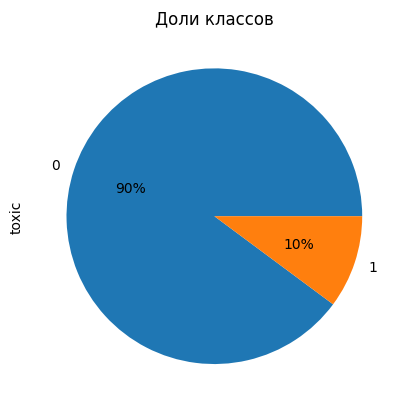

In [7]:
print(df['toxic'].value_counts())
print(df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1])
df['toxic'].value_counts().plot(kind='pie', title='Доли классов', autopct='%1.0f%%');

In [8]:
# Напишем функцию для уменьшение выборки
df = df.sample(159200).reset_index(drop=True)
df['toxic'].value_counts()

0    143028
1     16172
Name: toxic, dtype: int64

In [9]:
 df = df.sort_values('toxic').tail(34000)
 df['toxic'].value_counts()   

0    17828
1    16172
Name: toxic, dtype: int64

In [10]:
df.shape

(34000, 2)

In [11]:
# model_path = "martin-ha/toxic-comment-model"
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModel.from_pretrained(model_path).to('cuda:0')

In [12]:
# tokenized = df['text'].apply(
#   lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))
# max_vector = 512

In [13]:
# # применим padding к векторам
# # англ. вектор с отступами
# padded = np.array([i + [0]*(max_vector - len(i)) for i in tokenized.values])

# # создадим маску для важных токенов
# attention_mask = np.where(padded != 0, 1, 0)
# attention_mask.shape

In [14]:
# batch_size = 20
# embeddings = []
# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#     batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to('cuda:0')  
#     attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to('cuda:0')  
        
#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#     embeddings.append(batch_embeddings[0][:,0, :].cpu().numpy())
#     del batch, attention_mask_batch, batch_embeddings, 
#     torch.cuda.empty_cache()

In [15]:
# features = np.concatenate(embeddings)
# features.shape

In [16]:
# with open('bert2_tfidf.pickle', 'wb') as f:
#     pickle.dump(features, f)

In [17]:
with open('bert2_tfidf.pickle', 'rb') as f:
    features= pickle.load(f)
features.shape

(34000, 768)

In [18]:
train_features, test_features, train_target, test_target = train_test_split(
    features, df['toxic'], random_state=RANDOM_STATE, test_size=0.25)

In [19]:
skf = StratifiedKFold(n_splits=3)

## Обучение

### LogisticRegression

In [20]:
# Перебираемые гиперпараметры
grid_space_lr = {
    'max_iter': [100, 200, 500, 1000],                      
    'penalty': ['l1', 'l2'],                                   
}

In [21]:
# # обучающая модель
# lr = LogisticRegression()

# # обучим модель
# grid_lr= RandomizedSearchCV(lr, grid_space_lr,  verbose=1, cv=skf , n_jobs=-1, scoring='f1')
# grid_lr.fit(train_features, train_target) 

# print('Best hyperparameters are: '+str(grid_lr.best_params_))
# print('Best score is: '+str(grid_lr.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best hyperparameters are: {'penalty': 'l2', 'max_iter': 500}

Best score is: 0.8991731251863654

### RandomForest

In [22]:
# Перебираемые гиперпараметры
grid_space_forest = { 'n_estimators': range (20, 110, 10),
              'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'log2'],
              'max_depth': range (1,18, 2)
                    }

In [23]:
# # обучающая модель
# rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# # обучим модель
# grid_rfc= RandomizedSearchCV(rfc, grid_space_forest, cv=skf , scoring='f1')
# grid_rfc.fit(train_features, train_target) 

# print('Best hyperparameters are: '+str(grid_rfc.best_params_))
# print('Best score is: '+str(grid_rfc.best_score_))

Best hyperparameters are: {'n_estimators': 90, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'entropy'}

Best score is: 0.8980547185840931

### LightGBM

In [24]:
param_dist = {"max_depth": [5, 10, 20, 30, 40],
              "learning_rate" : [0.03, 0.1, 0.15, 0.3, 0.5],
              "num_leaves": [32, 150, 200, 300],
              "n_estimators": [100, 200, 300, 400, 500],
}

In [25]:
# model_lgb = LGBMClassifier(random_state=RANDOM_STATE)

# grid_search = RandomizedSearchCV(model_lgb, param_dist, cv = skf , 
#                                   verbose=10, n_jobs=-1, scoring='f1')
# grid_search.fit(train_features, train_target) 

# print('Best hyperparameters are: '+str(grid_search.best_params_))
# print('Best score is: '+str(grid_search.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters are: {'num_leaves': 300, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

Best score is: 0.8980630209922538

## Test

In [26]:
test_target.value_counts()

0    4476
1    4024
Name: toxic, dtype: int64

In [31]:
lgbm = LGBMClassifier(num_leaves=300, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE)

lgbm.fit(train_features, train_target)
predictions = lgbm.predict(test_features)

print(f'f1=',f1_score(test_target, predictions))

f1= 0.8961911874533234


In [28]:
lr = LogisticRegression(penalty='l2', max_iter=500)
lr.fit(train_features, train_target) 
predictions = lr.predict(test_features)

print(f'f1=',f1_score(test_target, predictions))

f1= 0.8922702373706635


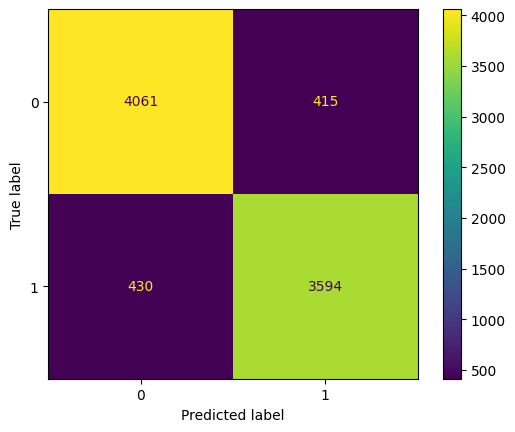

In [29]:
plot_confusion_matrix(lgbm, test_features, test_target); 

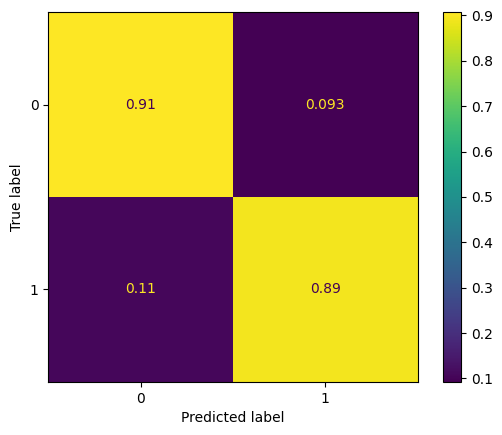

In [30]:
plot_confusion_matrix(lgbm, test_features, test_target, normalize='true'); 

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны